# Let's pretend that Max Scherzer wakes up tomorrow in a flat, featureless pocket universe. 

Let's agree that this place:

- Has a windless, Earth-like atmosphere set to STP and its air is uniform in density and temperature. (15C, 101.325kPa = 1225 kg/m<sup>3</sup>);
- is subject to Earth-like gravity (9.807 m/s<sup>2</sup>);
- where thrown objects do not roll upon impact with the ground;
- and isn't Cleveland.

Let's also state the obvious: Max wants to go home.


## The Lay of the Land
To Max's left is a Pandas DataFrame made manifest, which describes — in agonizing detail — every pitch he has ever thrown in the Major Leagues.

To Max's right is a surveyor's wheel, a granola bar, and a gold tablet, upon which, in Comic Sans, is writ a set of instructions:

>Hi Max:
>
>Per my previous email: 
>
>Welcome to <s>Cleveland</s> Nowhere. In order to leave, you must:
>1. **Reference** the DataFrame
>2. **Re-throw** the 1<sup>st</sup> pitch you threw in the Bigs
>3. At a **45° angle**
>4. Survey-wheel yourself on over **where the ball lands** (BTW: **it won't roll**, it'll just stick to the ground where you flang it)
>5. **Record the distance** you've walked
>6. Reference the DataFrame
>7. Re-throw the 2<sup>nd</sup> pitch you threw in the Bigs
>8. At a 45° angle
>9. Survey-wheel yourself on over to where the ball lands...
>10. ...
>11. Re-throw the 43,815<sup>th</sup> pitch you threw in the Bigs
>12. At a 45° angle.
>13. Survey-wheel yourself on over to where the ball lands
>14. Announce, out loud, **how far you've walked in total**.
>15. I already know the cumulative distance, but I need you to check my work.
>16. Thanks!

### Other Tacit Agreements

- Max, being the generational pitching talent that he is, is able to **throw a ball precisely as fast as he wants, and at an exact 45° angle**.

- Max, being the generational pitching talent that he is, **doesn't need to sleep or eat or drink or pee** here, and his arm never gets tired, and any other nullifying pedantry is also negated in full in the context of this ridiculous thought experiment.
- We're ignoring the stitches on the baseball.
- Any spin on the ball doesn't change during the baseball's journey. I don't have the energy to work that out.
- The drag force and the Magnus force can both be represented by simple functions of our ball's velocity<sup>2</sup>.


# WHAT EXACTLY ARE WE DOING HERE?

This thought experiment is a simple summing of an iterative projectile motion solve for distance, more or less. Thankfully, the field of basic mechanics is pretty well codified.

Double-thankfully, people smarter than me have already translated a ton of basic mechanics / work in this stupid space to code — mostly Python. So all I have to do is steal.

And by steal, I mean I'll be referencing other folks and trying to color inside their lines unless otherwise noted.


### Sources I've <s>Stolen</s> Learned From, to Whom This Nonsense Owes A Substantial Debt That Shall Never Be Repaid

1. [NASA's Entire Fucking Webpage About Modeling Baseball Dynamics](https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/aerodynamics-of-baseball/)
2. [Matthew West](https://dynref.engr.illinois.edu/afp.html)
3. [Jerron Lim](https://cocalc.com/share/public_paths/223c4e9ca1b913a9fa9d1d0f1028d90b7dc0b2d2)
4. Hall, I. N., & Nathan, A. M. (2009). [Determining the Drag Coefficient from PITCHf/x Data](http://baseball.physics.illinois.edu/LiftDrag-1.pdf)
5. Superstar MEGA Champion [Allen Downey](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/chapters/chap22.ipynb)
6. [The Effect of Air on Baseball Pitches](http://spiff.rit.edu/richmond/baseball/traj/traj.html#info) by Michael "Big Brains" Richard, 2009.
7. [Motion in Two and Three Dimensions](https://www2.tntech.edu/leap/murdock/books/v1chap3.pdf)

---


## Describing the Problem

### Part A: The Stuff
We need to know:
1. The baseball's mass
2. The baseball's diameter
3. Acceleration due to gravity
4. Initial velocities (direction and magnitude)
5. Drag coefficient

#### Hard stuff first: Drag coefficient

There are two reasons why most high school physics classrooms only consider gravity when attacking basic mechanics:
1. Science teachers love writing space-themed fanfic, and it's super fun to **pretend all of your problems in life exist in a vacuum**.
2. All of the non-gravitational forces are ***complicated***. 

But we're not in high school at the moment. 

So we're gonna try to Mr. Wizard some **air resistance** for Max and his Task, because he's made about $320 million playing baseball and he can catch a tough break for once in his incredible life.

## Drag Forces, Coefficients, and You

**Drag force** is pretty simple in the realm of basic mechanics. Here's the equation we're going to end up using:

$$ \vec{F}_{\rm D} = -F_{\rm D} \hat{v}, $$

But let's work through how it's derived.

The first part of our drag force equation, $ \vec{F}_{\rm D} $, is described by a **dimensionless drag coefficient** $ C_{\rm D} $, which is itself described by this ugliness:

$$ C_{\rm D} = \frac{F_{\rm D}}{\frac{1}{2} \rho A v^2} $$

It's not actually that ugly, though.

- $\rho$ = our air's **density**. (Technically: the density of the environmental fluid. And our <s>Cleveland</s> pocket universe is full of STP air.)
- $A$ = our baseball's **cross-sectional area**, which we can figure out with this badass equation: $\frac{1}{4}\pi D^2$
- $v$ = how hard Max throws the ball. E.g., its **initial velocity**.

### Meet our new best friend: the Reynolds number. 

Here's what she looks like.

$$ {\rm Re} = \frac{\rho v L}{\mu} $$

She, like our **drag coefficient**, is far from ugly: 
- $L$ = **Characteristic length of flow** — which, in this <s>Cleveland</s> thought experiment, is the diameter of the baseball $D$.
- $\mu$ = Our air's **dynamic viscosity**.

*The Reynolds number* can be thought of as **the link between our baseball's intertial forces and our air's viscous forces**.

It's important to note that when we're running our numbers, **we only care about the fluid forces that interact directly with our baseball**, as is described with this cute lil guy: $$ C_{\rm D} = C_{\rm D}({\rm Re}) $$
Basically, we're not trying to split the atom. We're trying to run Max through the ringer. 

Fluid dynamics can get super complicated faster than I can fail the AP Chemistry and Physics exams in the spring of 2002, but we're able to figure out a reasonable solve for our baseball's flight without spending big money on cloud compute — which, in the end, would just to overcomplicate the hell out of our lives for the sake of a negligible increase in accuracy in this here analytical domain of zero import and marginal amusement. 

And besides: our <s>Cleveland</s> MaxWorld™ is an infinite, windless doldrum. So we can ignore any "real" fluid dynamics on principle.

But getting back to our cute 'lil $ C_{\rm D} = C_{\rm D}({\rm Re}) $ ... 

### NASA to the Rescue

NASA gathered a ton of experimental data about projectiles in flight to try to quantify and chart the relationship between the Reynolds number and drag coefficients. 

The important thing here is the flat part of the chart, which is positioned more or less above $10^4$.

This is telling us that in this region of Newtonian spaghetti, drag force is pretty much proportional to the square of our baseball's speed. It's not exactly, completely, 100.0% proportional, of course. But let's live a little bit and say that it is.

![I Can't Believe NASA Did This](images/nasa-baseball-drag.jpeg)

Credit: [NASA](https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/drag-of-a-sphere/)



So if we substitute $ C_{\rm D} = \frac{1}{2} $ into our cute lil guy above, we get:

$$ F_{\rm D} = \frac{1}{4} \rho A v^2 = c v^2 $$

wherein we've pinned down the *quadratic drag parameter '$c$'* as:

$$ c = \frac{1}{4} \rho A = \frac{\pi}{16} \rho D^2 $$

which is a constant for our baseball. This is what we call *quadratic drag*, because the magnitude of the drag force is proportional to the square of our baseball's speed. 

### DRUM ROLL 

Using our shiny new *quadratic drag*, we can write our drag force vector as:

$$ \vec{F}_{\rm D} = - c v^2 \hat{v} $$

With this — and assuming we're still only considering gravity and quadratic drag — we can describe the forces on our baseball as:

$$ \sum \vec{F} = m \vec{g} - c v^2 \hat{v} $$

wherein $m$ = our baseball's mass, and $\vec{g}$ = local acceleration due to gravity.

---

## PUTTING IT ALL TOGETHER IN ONE EASY THROW
It's time for Max to launch his first baseball.

## * * * SPECIAL NOTE * * *

Note: in the interest of time, I'll be running our throws through a mish-mash of other peoples' work in this space — most hugely from Chapter 22 of Allen Downey's ["Modeling and Simulation in Python](https://nostarch.com/modeling-and-simulation-python), which he's generously hung on a very low branch located at the link I've hidden inside this emoji tree:

[🌳](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/chapters/chap22.ipynb)

Allen has done a bang-up job, and he has shared his work with me/us/everyone on the planet under the Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0) license. [Link to License](https://creativecommons.org/licenses/by-nc-sa/4.0/)

Allen does not in any way endorse my nonsense, but I have to believe that's just because he hasn't been introduced to it yet. 

Give me a call, Allen. 

I have snacks.

In [613]:
from tqdm import tqdm

# install Pint if necessary

try:
    from pint import UnitRegistry
except ImportError:
    %pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [614]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print(f'Downloaded {local}')
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

from modsim import *

# grab a handy-dandy drag force interpolationator
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'baseball_drag.csv')
baseball_drag = pd.read_csv('baseball_drag.csv')
mph_to_mps = (1 * units.mph).to(units.m/units.s).magnitude
speed = baseball_drag['Velocity in mph'] * mph_to_mps
C_d_series = make_series(speed, baseball_drag['Drag coefficient'])
drag_interp = interpolate(C_d_series)

In [615]:
# Model constants
g = 9.80665     # Acceleration due to gravity (m/s^2)
P = 1.225       # air density
M = 0.145       # Mass of baseball in kg
R = 3.683       # radius of baseball in cm
A = 0.00426     # baseball cross sectional area in m^2

In [616]:
# Let's quickly figure out the height from the ground that Max typically releases the baseball when he's pitching. This data is freely available from Major League Baseball. I've pulled Max's 2022 data from here, because I'm teleporting him in 2022 and I only care about his throwing mechanics from this year:

# https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2022%7C&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&team=&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&pitchers_lookup%5B%5D=453286&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc#results

release = pd.read_csv('data/scherzer_2022_release_point.csv')
release = release['release_pos_z'].str.replace("-","")
median_release = float(release.describe().top)

In [617]:
#Converting Max's median release point from feet to meters.

FEET_TO_M = 0.3048
release_point = median_release * FEET_TO_M
print(f"Max Scherzer's median release point is {round(release_point, 4)} meters from the ground.\n 1.7343 is our y0.")

Max Scherzer's median release point is 1.7343 meters from the ground.
 1.7343 is our y0.


In [618]:
# Describe the throw

throw = {
    "mph": float("95.7"),
    "theta": float("45.0"),
    "omega_rpm": float("2400.0"),
    "time": "1",
    "backspin": "1",
    "y0": float("1.7343")
}

In [619]:
# Converting the spin rate from revolutions per minute to radians per second.
throw["omega_radsec"] = throw["omega_rpm"] * 2 * np.pi / 60

# Converting the speed from miles per hour to meters per second.
throw["vt_msec"] = throw["mph"] * 1609 / 3600

# Calculating the x-component of the initial velocity.
throw["vx"] = throw["vt_msec"] * np.cos(throw["theta"])

# Calculating the y-component of the initial velocity.
throw["vy"] = throw["vt_msec"] * np.sin(throw["theta"])

# Converting the spin rate from radians per second to miles per hour
throw["vr_mph"] = R * throw["omega_radsec"] / 100 * 2.237

# Converting the spin rate from radians per second to meters per second
throw["vr_msec"] = R * throw["omega_radsec"] / 100

# This is the spin factor in meters per second.
throw["spin_factor"] = throw["vr_msec"] / throw["vt_msec"]

# Using the interpolation function to find the drag coefficient for the given speed.
throw["coeff_drag"] = float(drag_interp(throw["vt_msec"])) / 100

# Calculating the drag force.
throw["drag_force"] = (
    -0.5 * throw["coeff_drag"] * P * A * throw["vt_msec"] ** 2
)

# Calculating CL from spin force
if throw["spin_factor"] < 0.1:
    throw["coeff_lift"] = 1.6 * throw["spin_factor"]
else:
    throw["coeff_lift"] = 0.6 * throw["spin_factor"] + 0.1


# This is the Magnus force.
throw["magnus"] = (
    0.5 * throw["coeff_lift"] * P * A * throw["vt_msec"] ** 2
)


throw["fx"] = (
    -np.pi
    / 2
    * P
    * R**2
    * throw["vt_msec"]
    * (throw["coeff_lift"] * throw["vy"] + throw["drag_force"] * throw["vx"])
)

if throw["backspin"] == 1:
    throw["fy"] = (
        -np.pi
        / 2
        * P
        * R**2
        * throw["vt_msec"]
        * (throw["coeff_lift"] * throw["vx"] - throw["drag_force"] * throw["vy"])
    ) - M * g
else:
    throw["fy"] = (
        -np.pi
        / 2
        * P
        * R**2
        * throw["vt_msec"]
        * (-throw["coeff_lift"] * throw["vx"] - throw["drag_force"] * throw["vy"])
    ) - M * g

# Time of flight
# throw["time_of_flight"] = np.sqrt(-1 * 2 * throw["y0"] / g)

# Final Calc for X at T
# d_vx/dt = -kv(C_d * v_x + C_l * v_y)
# where k = P * pi * r^2/(2m)
throw["k"] = P * np.pi * (R**2 / 2 * M)



# Final Calc for Y at T
# d_vy/dt = kv(C_l * v_x - C_d * V_y) - g
# where k = d * pi * r^2/(2m)

In [620]:
# Let's see what a throw looks like at this point
throw

{'mph': 95.7,
 'theta': 45.0,
 'omega_rpm': 2400.0,
 'time': '1',
 'backspin': '1',
 'y0': 1.7343,
 'omega_radsec': 251.32741228718345,
 'vt_msec': 42.77258333333334,
 'vx': 22.46937854353875,
 'vy': 36.39534191176263,
 'vr_mph': 20.706541285979192,
 'vr_msec': 9.256388594536965,
 'spin_factor': 0.21640938828502598,
 'coeff_drag': 0.0031819701501515103,
 'drag_force': -0.015189474726260511,
 'coeff_lift': 0.2298456329710156,
 'magnus': 1.0971927039568097,
 'fx': -8958.111681619219,
 'fy': 5147.097894422013,
 'k': 3.784664666735842}

## Baseball

To model the flight of a baseball, we have to make some decisions. If we were smart, we'd try to ignore Magnus forces entirely and simulate our ball traveling in two dimensions instead of three.

So we'll try to incorporate Magnus forces in a little while.

## Simulating Baseball Flight

Let's simulate the flight of a baseball that thrown
at an angle of 45° and initial speed of however fast Max has to throw this pitch. His first pitch was thrown at 95.7 mph (42.7817 m/sec). We'll use his feet as the origin, a horizontal x-axis (parallel to the ground), and a vertical y-axis (perpendicular to the ground). Max throws from a low three-quarter release, and he's 6'3", The initial height is 1.7 m. C_d = 0.33 and C_l = 0.22 are good, lazy approximations for drag/lift coefficients, so we'll use those here.

Here's a `Params` object with the parameters we'll need.

In [622]:
params = Params(
    x = 0,          # m
    y = 1.7343,          # m
    angle = 45,     # degree
    speed = 42.7187,     # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = .33,
    C_l = .22, 

    rho = 1.225,        # kg/m**3
    g = 9.80665,        # m/s**2
    t_end = 10,         # s
)

I got the mass and diameter of the baseball from Wikipedia (see https://en.wikipedia.org/wiki/Baseball_(ball)). As usual, g is acceleration due to gravity. t_end is 10 seconds, which is long enough for the ball to land on the ground.

The following function uses these quantities to make a System object.

In [623]:
from numpy import pi, deg2rad, rad2deg

def make_system(params):
    
    # convert angle to degrees
    theta = deg2rad(params.angle)
    
    # compute x and y components of velocity
    # vx, vy = pol2cart(theta, params.speed)
    vx = throws["vx"][count]
    vy = throws["vy"][count]
    
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

make_system uses deg2rad to convert angle to radians and pol2cart to compute the  𝑥  and  𝑦  components of the initial velocity.

init is a State object with four state variables:

- x and y are the components of position.

- vx and vy are the components of velocity.

When we call System, we pass Params as the first argument, which means that the variables in Params are copied to the new System object.

Here's how we make the System object.

In [624]:
system = make_system(params)

And here's the initial State:

In [625]:
show(system.init)

,state
x,0.000000
y,1.734300
vx,20.098002
vy,32.554245


## Drag Force

Next we need a function to compute drag force:

In [626]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area

    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    return mag * direction

This function takes V as a Vector and returns f_drag as a Vector.

It uses vector_mag to compute the magnitude of V, and the drag equation to compute the magnitude of the drag force, mag.

Then it uses vector_hat to compute direction, which is a unit vector in the opposite direction of V.

Finally, it computes the drag force vector by multiplying mag and direction.

We can test it like this:

In [628]:
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = drag_force(V_test, system)
# f_drag = throw['drag_force']
show(f_drag)

-0.015189474726260511

The result is a Vector that represents the drag force on the baseball, in Newtons, under the initial conditions.

Now we can add drag to the slope function.

In [643]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = throw['drag_force'] / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

As usual, the parameters of the slope function are a time stamp, a State object, and a System object. We don't use t in this example, but we can't leave it out because when run_solve_ivp calls the slope function, it always provides the same arguments, whether they are needed or not.

slope_func unpacks the State object into variables x, y, vx, and vy. Then it packs vx and vy into a Vector, which it uses to compute drag force, f_drag, and acceleration due to drag, a_drag.

To represent acceleration due to gravity, it makes a Vector with magnitude g in the negative  𝑦  direction.

The total acceleration of the baseball, A, is the sum of accelerations due to gravity and drag.

The return value is a sequence that contains:

- The components of velocity, V.x and V.y.

- The components of acceleration, A.x and A.y.

These components represent the slope of the state variables, because V is the derivative of position and A is the derivative of velocity.

As always, we can test the slope function by running it with the initial conditions:

Using vectors to represent forces and accelerations makes the code concise, readable, and less error-prone. In particular, when we add a_grav and a_drag, the directions are likely to be correct, because they are encoded in the Vector objects.

In [644]:
slope_func(0, system.init, system)

(20.098002124628177,
 32.554245220970536,
 -0.10475499811214146,
 -9.911404998112141)

## Adding an Event Function

We're almost ready to run the simulation. The last thing we need is an event function that stops when the ball hits the ground.

In [645]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

The event function takes the same parameters as the slope function, and returns the  𝑦  coordinate of position. When the  𝑦  coordinate passes through 0, the simulation stops.

As we did with slope_func, we can test event_func with the initial conditions.

In [646]:
event_func(0, system.init, system)

1.7343

Here's how we run the simulation with this event function:

In [647]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

The message indicates that a "termination event" occurred; that is, the simulated ball reached the ground.

results is a TimeFrame with one row for each time step and one column for each of the state variables. Here are the last few rows.

In [648]:
results.tail()

,x,y,vx,vy
6.357021,125.646750,8.413889,19.432072,-30.452761
6.423240,126.933292,6.375609,19.425136,-31.109084
6.489459,128.219375,4.293867,19.418199,-31.765407
6.555678,129.504998,2.168664,19.411262,-32.421730
6.621897,130.790162,0.000000,19.404325,-33.078053


We can get the flight time like this:

In [649]:
flight_time = results.index[-1]
flight_time

6.621896501820102

And the final state like this:

In [650]:
final_state = results.iloc[-1]
show(final_state)

,6.621897
x,130.790162
y,0.000000
vx,19.404325
vy,-33.078053


The final value of y is close to 0, as it should be. The final value of x tells us how far the ball flew, in meters.

In [651]:
x_dist = final_state.x
x_dist

130.79016212217314

We can also get the final velocity, like this:

In [652]:
final_V = Vector(final_state.vx, final_state.vy)
show(final_V)

,component
x,19.404325
y,-33.078053


## Visualizing Trajectories

To visualize the results, we can plot the $x$ and $y$ components of position like this:

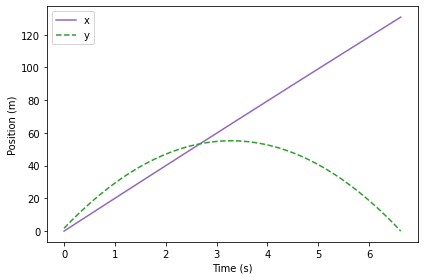

In [653]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

As expected, the  𝑥  component increases as the ball moves away from home plate. The  𝑦  position climbs initially and then descends, falling to 0 m after 6.0 s.

Another way to view the results is to plot the  𝑥  component on the  𝑥 -axis and the  𝑦  component on the  𝑦 -axis, so the plotted line follows the trajectory of the ball through the plane:

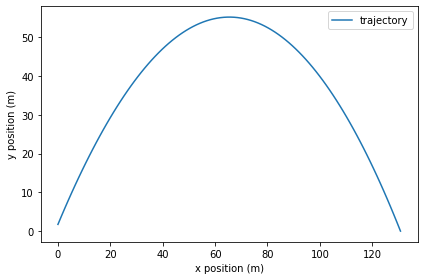

In [654]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

This way of visualizing the results is called a trajectory plot (see http://modsimpy.com/trajec). A trajectory plot can be easier to interpret than a time series plot, because it shows what the motion of the projectile would look like (at least from one point of view). Both plots can be useful, but don't get them mixed up! If you are looking at a time series plot and interpreting it as a trajectory, you will be very confused.

Notice that the trajectory is not symmetric. With a launch angle of 45°, the landing angle is closer to vertical, about 57° degrees.

In [655]:
rad2deg(vector_angle(final_V))

-59.603160986099006

# ENOUGH ALREADY, SHOW ME SOME THROWS

In [729]:
# Import all of Max Scherzer's pitches

# Data avenue 1:
# https://baseballsavant.mlb.com/savant-player/max-scherzer-453286?stats=statcast-r-pitching-mlb#pitch_tracking

# Data avenue 2:
# https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2022%7C2021%7C2020%7C2019%7C2018%7C2017%7C2016%7C2015%7C2014%7C2013%7C2012%7C2011%7C2010%7C2009%7C2008%7C&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&team=&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&pitchers_lookup%5B%5D=453286&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc#results

# Note about second link: For whatever reason, Savant isn't including 2008-9 in this data export. But the data does exist. So a separate search for 2008-9 and then a merge or a cut/paste into 2010-22 yields the final csv, which I've included in the repo.

df = pd.read_csv('data/scherzer_pitches.csv', low_memory=False)
df = df.convert_dtypes()

In [751]:
throws = df[['game_date', 'pitch_name', 'release_extension', 'release_speed', 'release_spin_rate', 'spin_axis', 'release_pos_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']].copy()

throws = throws.convert_dtypes()

In [755]:
# Converting the spin rate from revolutions per minute to radians per second.
throws["theta"] = float(45)

# Converting the spin rate from revolutions per minute to radians per second.
throws["omega_radsec"] = throws["release_spin_rate"] * 2 * np.pi / 60

# Converting the speed from miles per hour to meters per second.
throws["vt_msec"] = throws["release_speed"] * 1609 / 3600

# Calculating the x-component of the initial velocity.
throws["vx"] = throws["vt_msec"] * np.cos(throws["theta"])

# Calculating the y-component of the initial velocity.
throws["vy"] = throws["vt_msec"] * np.sin(throws["theta"])

# Converting the spin rate from radians per second to miles per hour
throws["vr_mph"] = R * throws["omega_radsec"] / 100 * 2.237

# Converting the spin rate from radians per second to meters per second
throws["vr_msec"] = R * throws["omega_radsec"] / 100

# This is the spin factor in meters per second.
throws["spin_factor"] = throws["vr_msec"] / throws["vt_msec"]



In [765]:
throws['spin_factor'] = throws['spin_factor'].fillna(0)

In [764]:

# Calculating CL from spin force
count = 0
try:
    for throw in tqdm(range(len(throws))):
        if throws.iloc[count]["spin_factor"] <= 0.1:
            throws.iloc[count]["coeff_lift"] = 1.6 * throws.iloc[count]["spin_factor"]
        else:
            throws.iloc[count]["coeff_lift"] = 0.6 * throws.iloc[count]["spin_factor"] + 0.1
        count += 1
except Exception:
    print(f"{count} couldn't process")
    count += 1


  0%|          | 0/44002 [00:00<?, ?it/s]/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/3836213710.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throws.iloc[count]["coeff_lift"] = 0.6 * throws.iloc[count]["spin_factor"] + 0.1
/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/3836213710.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throws.iloc[count]["coeff_lift"] = 0.6 * throws.iloc[count]["spin_factor"] + 0.1
/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/3836213710.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

3476 couldn't process


In [740]:
throws['spin_factor'].isna().value_counts()

True     22253
False    21749
Name: spin_factor, dtype: int64

In [710]:
throws.iloc[0]["spin_factor"]

AttributeError: 'int' object has no attribute 'iloc'

In [689]:
msecs = throws["vt_msec"].fillna(0).tolist()

In [690]:
drag_interps = []
count = 0
try:
    for msec in range(len(msecs)):
        a = interp(msecs[count]) / 100
        drag_interps.append(a)
        count += 1
except:
    print(f"{count} had a problem")
    count += 1

In [691]:
throws["vt_msec"][0]

37.72211111111111

In [692]:
def interp(msec):
    di = float(drag_interp(msec))
    return di

In [693]:
throws = throws.convert_dtypes()

In [694]:
vts = []
count = 0
for throw in range(len(throws)):
    msec = throws["vt_msec"][throw]
    vts.append(msec)
    count += 1

In [695]:
vtsconvert = pd.DataFrame(vts)
vtsconvert = vtsconvert.fillna(0)
vtsconvert = vtsconvert.astype(float)
vtslist = vtsconvert[0].tolist()

In [702]:
drags = []
count = 0
for msec in range(len(vtslist)):
    msecs = interp(vtslist[count]) / 100
    drags.append(msecs)
    count += 1

#Assigning the values of the `drags` variable to the `throws["coeff_drag"]` column.
throws["coeff_drag"] = drags

In [703]:
throws.sample()

,game_date,pitch_name,release_extension,release_speed,release_spin_rate,spin_axis,release_pos_z,vx0,vy0,vz0,...,theta,omega_radsec,vt_msec,vx,vy,vr_mph,vr_msec,spin_factor,backspin,coeff_drag
11440,5/6/18,4-Seam Fastball,6.1,94.8,2529,215,5.2,12.047219,-137.571524,-1.108666,...,45,264.836261,42.370333,22.258068,36.053066,21.819518,9.753919,0.230206,1,0.003204


# WORK FROM HERE
- finish adding backspin bool
- add coeff drag column
- add drag force column
- add lift force column?? Decide soon.
- drags = drag coeff list, comment those loops

In [704]:
def pitch(row):
      try:
            if row['pitch_name'] == 'Curveball' or row['pitch_name'] == 'Slider':
                  return '0'
            else:
                  return '1'
      except:
            pass


In [705]:
throws['backspin'] = throws.apply(pitch, axis=1)

In [707]:


count = 0
for throw in tqdm(range(len(throws))):
    
    # Calculating the drag force.
    throws.iloc[count]["drag_force"] = (
        -0.5 * throws.iloc[count]["coeff_drag"] * P * A * throws.iloc[count]["vt_msec"] ** 2
    )

    # Calculating lift coefficient from spin force
    try:
        if throws[(throws.iloc[count]["spin_factor"] <= 0.1)]:
            throws.iloc[count]["coeff_lift"] = (1.6 * throws.iloc[count]["spin_factor"])
        else:
            throws.iloc[count]["coeff_lift"] = (0.6 * throws.iloc[count]["spin_factor"] + 0.1)
    except:
        throws.iloc[count]["coeff_lift"] = 0.22

    throws["fx"] = (
        -np.pi
        / 2
        * P
        * R**2
        * throws["vt_msec"]
        * (throws["coeff_lift"] * throws["vy"] + throws["drag_force"] * throws["vx"]) / 100
    )
    
    try:
        if throws[(throws["backspin"] == 1)]:
            throws["fy"] = (
                -np.pi
                / 2
                * P
                * R**2
                * throws["vt_msec"]
                * (throws["coeff_lift"] * throws["vx"] - throws["drag_force"] * throws["vy"])) - M * g
            # This is the Magnus force.
            throws["magnus"] = (0.5 * throws["coeff_lift"] * P * A * throws["vt_msec"] ** 2)

        elif throws[(throws["backspin"] == 0) & (throws["backspin"].notna())]:
            throws["fy"] = (-np.pi/ 2* P* R**2* throws["vt_msec"] * (-throws["coeff_lift"] * throws["vx"] - throws["drag_force"] * throws["vy"])) - M * g
            throws["magnus"] = -(0.5 * throws["coeff_lift"] * P * A * throws["vt_msec"] ** 2)
        else: pass 
    except:
        pass

    throws["k"] = P * np.pi * (R**2 / 2 * M)
    count += 1

  0%|          | 0/44002 [00:00<?, ?it/s]/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/4039343511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throws.iloc[count]["drag_force"] = (
/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/4039343511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throws.iloc[count]["drag_force"] = (
/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/4039343511.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

KeyError: 'coeff_lift'

In [671]:
from numpy import pi, deg2rad

def make_system(params):
    
    # convert angle to degrees
    theta = deg2rad(params.angle)
    
    # compute x and y components of velocity, id'd by our counter
    vx = throws.iloc[count]["vx"]
    vy = throws.iloc[count]["vy"]
    
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

In [672]:
throws.columns

Index(['game_date', 'pitch_name', 'release_extension', 'release_speed',
       'release_spin_rate', 'spin_axis', 'release_pos_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'theta', 'omega_radsec', 'vt_msec', 'vx', 'vy',
       'vr_mph', 'vr_msec', 'spin_factor', 'backspin', 'coeff_drag',
       'drag_force', 'coeff_lift', 'magnus', 'fx', 'k'],
      dtype='object')

In [673]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = throws.iloc[count]["drag_force"]
    # a_drag = drag_force(V, system) / mass
    a_grav = g * Vector(0, -1)
    a_lift = throws.iloc[count]["magnus"]
    
    A = a_grav + a_drag + a_lift
    
    return V.x, V.y, A.x, A.y

In [674]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

In [675]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)

Before running scipy.integrate.solve_ivp, I tried
                 running the slope function you provided with the
                 initial conditions in `system` and `t=t_0` and I got
                 the following error:


KeyError: 44002

In [680]:
throws.iloc[count]["flight_time"]

7.18486374683051

In [683]:
count = 0
for throw in tqdm(range(10)):
    params = Params(
        x = 0,          # m
        y = 1.7343,          # m
        angle = 45,     # degree
        # speed = 44.34,     # m / s
        speed = throws.iloc[count]["vt_msec"],     # m / s

        mass = 145e-3,    # kg 
        diameter = 73e-3, # m 
        C_d = throws.iloc[count]["coeff_drag"],       # dimensionless
        C_l = throws.iloc[count]["coeff_lift"],
        

        rho = 1.225,      # kg/m**3
        g = 9.806,        # m/s**2
        t_end = 10,     # s
    )
    
    system = make_system(params)
    
    results, details = run_solve_ivp(system, slope_func,
                                events=event_func)
    
    flight_time = results.index[-1]
    throws.iloc[count]["flight_time"] = flight_time
    
    final_state = results.iloc[-1]
    x_dist = final_state.x
    y_dist = final_state.y
    vx_final = final_state.vx
    vy_final = final_state.vy

    throws.iloc[count]["x_dist"] = x_dist
    throws.iloc[count]["y_dist"] = y_dist
    throws.iloc[count]["vx_final"] = vx_final
    throws.iloc[count]["vy_final"] = vy_final
    
    final_V = Vector(final_state.vx, final_state.vy)
    throws.iloc[count]["final_V"] = final_V
    
    count += 1

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/3307131881.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throws.iloc[count]["flight_time"] = flight_time
/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/3307131881.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throws.iloc[count]["x_dist"] = x_dist
/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_69771/3307131881.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [684]:
throws.head()

,game_date,pitch_name,release_extension,release_speed,release_spin_rate,spin_axis,release_pos_z,vx0,vy0,vz0,...,vr_msec,spin_factor,backspin,coeff_drag,drag_force,coeff_lift,magnus,fx,k,flight_time
0,7/16/22,Slider,6.2,84.4,2356,139,5.28,8.348185,-122.797725,-2.474601,...,9.086688,0.240885,0,0.003469,-0.01288,0.22,0.816828,-67.014172,3.784665,7.184864
1,7/16/22,Slider,6.2,84.2,2324,117,5.38,5.598506,-122.490258,-1.081059,...,8.96327,0.238178,0,0.003474,-0.012838,0.22,0.812961,-66.705016,3.784665,7.184864
2,7/16/22,4-Seam Fastball,6.3,93.2,2475,225,5.44,14.748374,-134.933904,-5.576836,...,9.545651,0.229159,1,0.003243,-0.014682,0.22,0.996041,-81.288415,3.784665,7.184864
3,7/16/22,Curveball,6.4,71.1,2743,62,5.53,1.366678,-103.510146,2.524086,...,10.579281,0.332915,0,0.003951,-0.010412,0.22,0.579675,-47.899475,3.784665,7.184864
4,7/16/22,4-Seam Fastball,6.3,92.5,2368,221,5.44,7.593156,-134.464632,-4.170791,...,9.13297,0.220911,1,0.003260,-0.014539,0.22,0.981135,-80.105587,3.784665,7.184864


In [510]:
throws.drop(columns = ['time_of_flight'])

,game_date,pitch_name,release_extension,release_speed,release_spin_rate,spin_axis,release_pos_z,vx0,vy0,vz0,...,magnus,fx,time_of_flight,k,flight_time,x_dist,y_dist,vx_final,vy_final,final_V
0,7/16/22,Slider,6.2,84.4,2356,139,5.28,8.348185,-122.797725,-2.474601,...,0.816828,-67.014172,NaN,3.784665,6.637916,109.453254,-3.552714e-14,13.263809,-24.984708,NaN
1,7/16/22,Slider,6.2,84.2,2324,117,5.38,5.598506,-122.490258,-1.081059,...,0.812961,-66.705016,NaN,3.784665,6.637916,109.453254,-3.552714e-14,13.263809,-24.984708,NaN
2,7/16/22,4-Seam Fastball,6.3,93.2,2475,225,5.44,14.748374,-134.933904,-5.576836,...,0.996041,-81.288415,NaN,3.784665,6.637916,109.453254,-3.552714e-14,13.263809,-24.984708,NaN
3,7/16/22,Curveball,6.4,71.1,2743,62,5.53,1.366678,-103.510146,2.524086,...,0.579675,-47.899475,NaN,3.784665,6.637916,109.453254,-3.552714e-14,13.263809,-24.984708,NaN
4,7/16/22,4-Seam Fastball,6.3,92.5,2368,221,5.44,7.593156,-134.464632,-4.170791,...,0.981135,-80.105587,NaN,3.784665,6.637916,109.453254,-3.552714e-14,13.263809,-24.984708,NaN


In [503]:
final_state = results.iloc[-1]
x_dist = final_state.x
y_dist = final_state.y
vx_final = final_state.vx
vy_final = final_state.vy

throws["x_dist"] = x_dist
throws["y_dist"] = y_dist
throws["vx_final"] = vx_final
throws["vy_final"] = vy_final

,6.637916
x,1.094533e+02
y,-3.552714e-14
vx,1.326381e+01
vy,-2.498471e+01


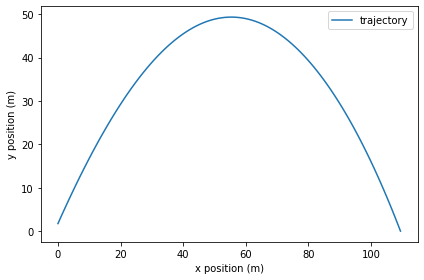

In [506]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)